In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [2]:
def wrangle(file):

    #read csv
    df = pd.read_csv(file)

    # columns to drop due to high missing values
    cols_to_drop = ['Year', 'Class', 'Adm1', 'Adm6', 'Geo1', 'econ4', 'Adm3', 'Adm4', 'Adm5', 'Econ0', 'econ1', 'econ2', 'econ3', 'FndSrce1', 'function1', 'function2']
      
    #drop columns
    df.drop(columns = cols_to_drop, inplace=True)

    #remove empty spaces
    df.columns = df.columns.str.strip()

    #Remove characters from target numerical columns
    num_cols = ['Estimates', 'Revised', 'Executed']
    for col in num_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.replace(r'[^\d.-]', '', regex=True) 
        df[col] = df[col].replace(r'^\s*$', 'NaN', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    
    #handle missing data
    
    df.dropna(inplace=True) # Drop missing rows
    

    #change column names
    df.columns = ['Ministry', 'Estimates', 'Revised', 'Executed']
    
    #remove ministry code 
    df['Ministry'] = df['Ministry'].str.replace(r'^\d+\s*', '', regex=True)
    #mask to get only ministries
    mask = df['Ministry'].str.contains('Ministry')
    
    df = df[mask]

    #return dataframe
    return df

In [3]:
df = wrangle('kenya-boost-2006-2018.csv')
df.head()


/tmp/ipykernel_2811/3459501992.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Ministry,Estimates,Revised,Executed
0,Ministry of Agriculture,18318600.0,14062700.0,5893860.0
1,Ministry of Agriculture,12799450.0,9599587.0,3312808.0
2,Ministry of Agriculture,7218400.0,5652150.0,2911400.0
3,Ministry of Agriculture,10025827.0,8126744.0,4501504.0
4,Ministry of Agriculture,500000.0,1130625.0,95000.0


In [4]:
print('Shape of DataFrame', df.shape)

Shape of DataFrame (65073, 4)


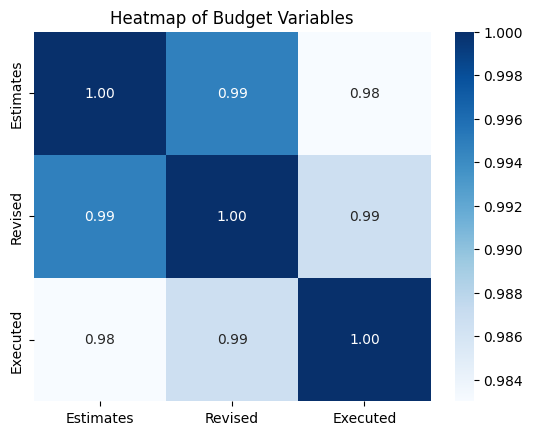

In [5]:
#find correlation
corr = df.drop(columns='Ministry').corr()#get correlation of numerical budget variables
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")#visualize correlation matrix
plt.title('Heatmap of Budget Variables');# title for heatmap


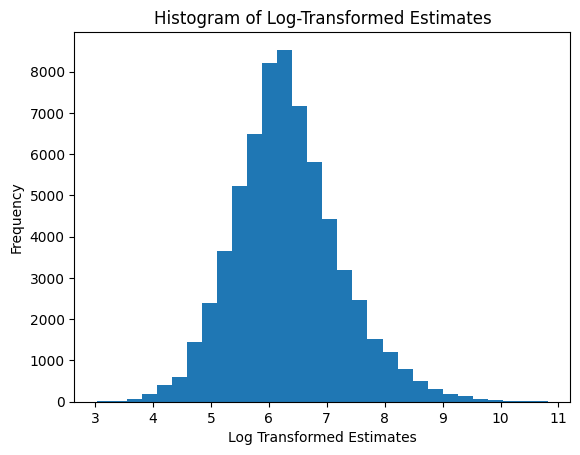

In [6]:
#visualize estimate variable

estimates = np.log10(df['Estimates'])#log10 since data spans large magnitude
estimates.plot(kind='hist', bins = 30)#plot histogram
plt.xlabel('Log Transformed Estimates')#label x-axis
plt.ylabel('Frequency')#label y axis
plt.title('Histogram of Log-Transformed Estimates'); #title

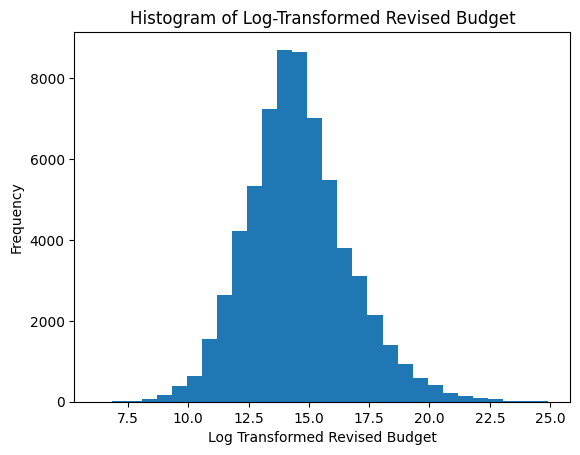

In [7]:
#visualize revised budgets

revised = np.log1p(df['Revised'])# log 1p since there are zeros
revised.plot(kind='hist', bins = 30)#plot histogram
plt.xlabel('Log Transformed Revised Budget')#label x-axis
plt.ylabel('Frequency')#label y axis
plt.title('Histogram of Log-Transformed Revised Budget'); #title

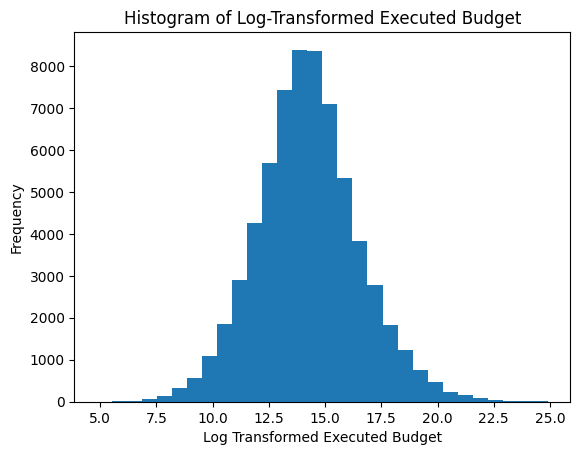

In [8]:
#visualize executed budget

executed = np.log1p(df['Executed'])# log 1p since there are zeros
executed.plot(kind='hist', bins = 30)#plot histogram
plt.xlabel('Log Transformed Executed Budget')#label x-axis
plt.ylabel('Frequency')#label y axis
plt.title('Histogram of Log-Transformed Executed Budget'); #title

In [9]:
#encode categorical variable
categorical = df.select_dtypes('object').columns
cat_dummies_df = pd.get_dummies(df[categorical], drop_first=True).astype('int')
cat_dummies_df.head()

,Ministry_Ministry of Cooperative Development and Marketing,Ministry_Ministry of Development of Northern Kenya and Other Arid Lands,Ministry_Ministry of East African Community,Ministry_Ministry of Education,Ministry_Ministry of Energy,Ministry_Ministry of Environment and Mineral Resources,Ministry_Ministry of Finance,Ministry_Ministry of Fisheries Development,Ministry_Ministry of Foreign Affairs,Ministry_Ministry of Forestry and Wildlife,...,Ministry_Ministry of State for Public Service,Ministry_Ministry of State for Special Programmes,Ministry_Ministry of Tourism,Ministry_Ministry of Trade,Ministry_Ministry of Transport,Ministry_Ministry of Water and Irrigation,Ministry_Ministry of Youth Affairs and Sports,Ministry_Ministry of lnformation and Communications,Ministry_Office of the Deputy Prime Minister and Ministry of Local Government,Ministry_Office of the Vice President and Ministry of Home Affairs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#get numerical variables
num_variables = df.select_dtypes(['float','int']).columns
num_df = df[num_variables]
num_df.head()

,Estimates,Revised,Executed
0,18318600.0,14062700.0,5893860.0
1,12799450.0,9599587.0,3312808.0
2,7218400.0,5652150.0,2911400.0
3,10025827.0,8126744.0,4501504.0
4,500000.0,1130625.0,95000.0


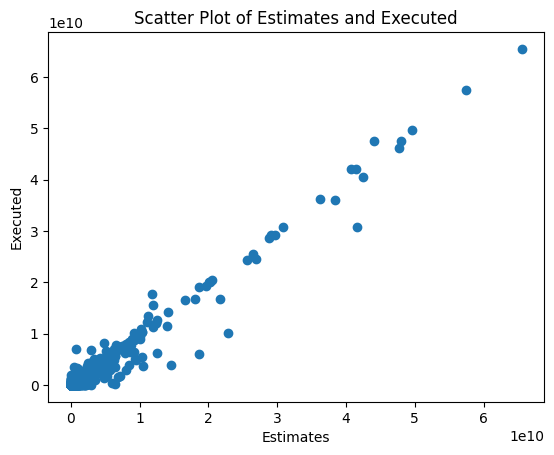

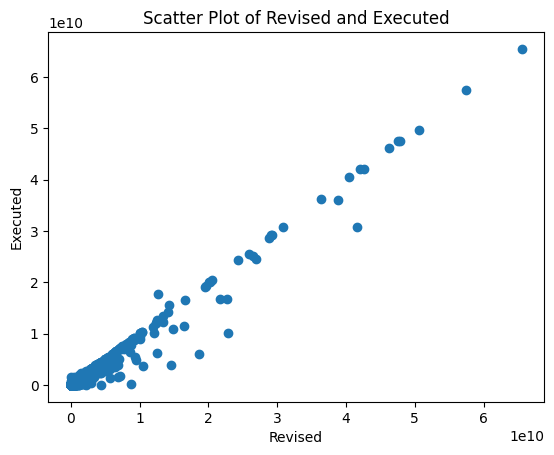

In [11]:
def scatter_plot(file):
    features = file.drop('Executed', axis=1) #drop target
    target = file['Executed']
    x_feat = features.columns #get feature names
    for feat in x_feat:
        x = file[feat]
        y = target
        fig = plt.scatter(x, y)#plot scatter
        plt.xlabel(x.name)
        plt.ylabel(y.name)
        plt.title(f'Scatter Plot of {x.name} and {y.name}')
        plt.show()
fig = scatter_plot(num_df)
fig

In [12]:
#concatenate
df_new = pd.concat([cat_dummies_df, num_df], axis=1)
df_new.head()

,Ministry_Ministry of Cooperative Development and Marketing,Ministry_Ministry of Development of Northern Kenya and Other Arid Lands,Ministry_Ministry of East African Community,Ministry_Ministry of Education,Ministry_Ministry of Energy,Ministry_Ministry of Environment and Mineral Resources,Ministry_Ministry of Finance,Ministry_Ministry of Fisheries Development,Ministry_Ministry of Foreign Affairs,Ministry_Ministry of Forestry and Wildlife,...,Ministry_Ministry of Trade,Ministry_Ministry of Transport,Ministry_Ministry of Water and Irrigation,Ministry_Ministry of Youth Affairs and Sports,Ministry_Ministry of lnformation and Communications,Ministry_Office of the Deputy Prime Minister and Ministry of Local Government,Ministry_Office of the Vice President and Ministry of Home Affairs,Estimates,Revised,Executed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18318600.0,14062700.0,5893860.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,12799450.0,9599587.0,3312808.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7218400.0,5652150.0,2911400.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10025827.0,8126744.0,4501504.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,500000.0,1130625.0,95000.0


In [13]:
#get predictors and predicted
X = df_new.drop('Executed', axis=1) 
y = df_new['Executed']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (52058, 41)
Shape of X_test (13015, 41)
Shape of y_train (52058,)
Shape of y_test (13015,)


In [44]:
def linear_model_training():
    
    #baseline mae
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print('Linear Model Results')
    print('MAE Baseline:', mae_baseline)
    
    #Instantiate model
    model = LinearRegression()
    #fit model
    model.fit(X_train, y_train)
    
    #Mae training
    y_pred_training = model.predict(X_train)
    mae_training = mean_absolute_error(y_train, y_pred_training)
    print('MAE Training:', mae_training)
    print('Train R2 Score:', model.score(X_train, y_train))

    #Mae testing

    y_pred_testing = model.predict(X_test)
    mae_testing = mean_absolute_error(y_test, y_pred_testing)
    print('MAE Testing:', mae_testing)
    print('Test R2 Score:', model.score(X_test, y_test))
    print("-------------------------------------------")
    results = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_
    })
    print(results.sort_values(by='Coefficient', ascending=False))
    

In [15]:
def ridge_model_training():
    
    #baseline mae
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print('Ridge Model Results')
    print('MAE Baseline:', mae_baseline)
    
    #Instantiate model
    model = Ridge(alpha=1.0)
    #fit model
    model.fit(X_train, y_train)
    
    #Mae training
    y_pred_training = model.predict(X_train)
    mae_training = mean_absolute_error(y_train, y_pred_training)
    print('MAE Training:', mae_training)
    print('Train R2 Score:', model.score(X_train, y_train))

    #Mae testing

    y_pred_testing = model.predict(X_test)
    mae_testing = mean_absolute_error(y_test, y_pred_testing)
    print('MAE Testing:', mae_testing)
    print('Test R2 Score:', model.score(X_test, y_test))
    print("-------------------------------------------")


In [16]:
def lasso_model_training():
    
    #baseline mae
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print('Lasso Model Results')
    print('MAE Baseline:', mae_baseline)

    
    #Instantiate model
    model = Lasso(alpha=1.0)
    #fit model
    model.fit(X_train, y_train)
    
    #Mae training
    y_pred_training = model.predict(X_train)
    mae_training = mean_absolute_error(y_train, y_pred_training)
    print('MAE Training:', mae_training)
    print('Train R2 Score:', model.score(X_train, y_train))

    #Mae testing

    y_pred_testing = model.predict(X_test)
    mae_testing = mean_absolute_error(y_test, y_pred_testing)
    print('MAE Testing:', mae_testing)
    print('Test R2 Score:', model.score(X_test, y_test))
    print("-------------------------------------------")

In [45]:
#linear model results
lmodel_results = linear_model_training()
lmodel_results



Linear Model Results
MAE Baseline: 79181436.84225465
MAE Training: 11817412.373216577
Train R2 Score: 0.9784102642182217
MAE Testing: 13705344.179489711
Test R2 Score: 0.9598356751319336
-------------------------------------------
                                              Feature   Coefficient
24             Ministry_Ministry of State for Defence  1.998565e+07
3                      Ministry_Ministry of Education  9.662980e+06
25  Ministry_Ministry of State for Immigration and...  6.210841e+06
2         Ministry_Ministry of East African Community  3.997029e+06
29      Ministry_Ministry of State for Public Service  3.805904e+06
0   Ministry_Ministry of Cooperative Development a...  3.515380e+06
26  Ministry_Ministry of State for National Herita...  3.466062e+06
8                Ministry_Ministry of Foreign Affairs  3.430846e+06
32                         Ministry_Ministry of Trade  3.322663e+06
15                        Ministry_Ministry of Labour  3.096678e+06
38  Ministry_Office o

In [18]:
#ridge model results
rmodel_results = ridge_model_training()
rmodel_results

Ridge Model Results
MAE Baseline: 79181436.84225465
MAE Training: 11815787.04229924
Train R2 Score: 0.9784102639637361
MAE Testing: 13703775.81653351
Test R2 Score: 0.9598355009808281
-------------------------------------------


/home/paudev/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.64854e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [19]:
#lasso model results
lmodel_results = lasso_model_training()
lmodel_results

Lasso Model Results
MAE Baseline: 79181436.84225465


MAE Training: 11817408.253696704
Train R2 Score: 0.9784102642180512
MAE Testing: 13705338.193867654
Test R2 Score: 0.959835682398404
-------------------------------------------


/home/paudev/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.376e+20, tolerance: 3.127e+18
  model = cd_fast.enet_coordinate_descent(


In [27]:
def num_training(file):
    X = file.drop('Executed', axis=1) #drop target
    y = file['Executed']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('Shape of X_train', X_train.shape)
    print('Shape of X_test', X_test.shape)
    print('Shape of y_train', y_train.shape)
    print('Shape of y_test', y_test.shape)
    #baseline mae
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print('Linear Model Results')
    print('MAE Baseline:', mae_baseline)
    
    #Instantiate model
    model = LinearRegression()
    #fit model
    model.fit(X_train, y_train)
    
    #Mae training
    y_pred_training = model.predict(X_train)
    mae_training = mean_absolute_error(y_train, y_pred_training)
    print('MAE Training:', mae_training)
    print('Train R2 Score:', model.score(X_train, y_train))

    #Mae testing

    y_pred_testing = model.predict(X_test)
    mae_testing = mean_absolute_error(y_test, y_pred_testing)
    print('MAE Testing:', mae_testing)
    print('Test R2 Score:', model.score(X_test, y_test))
    print("-------------------------------------------")
    print(model.coef_)
    
    

In [28]:
num_training(num_df)

Shape of X_train (52058, 2)
Shape of X_test (13015, 2)
Shape of y_train (52058,)
Shape of y_test (13015,)
Linear Model Results
MAE Baseline: 79181436.84225465
MAE Training: 11140180.579281254
Train R2 Score: 0.978227134113651
MAE Testing: 13024303.41777401
Test R2 Score: 0.9594924017769499
-------------------------------------------
[0.10801674 0.83870632]
